In [32]:
import tensorflow as tf
from deeponet import DeepONet
from utils import *
import matplotlib.pyplot as plt

In [33]:
device = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"
print("Device :", device)

Device : /cpu:0


In [34]:
@tf.function
def boundary_fn(x, boundaries = (0.0, 1.0)):
    return (x[..., 0] - boundaries[0]) * (x[..., 0] - boundaries[1]) * (x[..., 1] - boundaries[0]) * (x[..., 1] - boundaries[1]) 

model = DeepONet(
    n_branch = 64 * 64, 
    n_trunk = 2, 
    width = 40, 
    depth = 2, 
    output_dim = 128 * 128,
    activation = "relu", 
    boundary_fn=boundary_fn
)


In [35]:
dataloader = DarcyDatasetLoader("DarcyDataset")
train_dataset, test_dataset = dataloader.get_split(0.2, batch_size = 128)

16384


In [36]:
def downsample(a, u):
    a = tf.expand_dims(a, axis=-1)  # Shape now [batch, height, width, 1]

    # Apply Max Pooling to downsample `a`
    pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
    a_downsampled = pooling_layer(a)

    # Remove the channel dimension if you want to return it to its original format
    a_downsampled = tf.squeeze(a_downsampled, axis=-1)

    return a_downsampled, u    

In [37]:
train_dataset = train_dataset.map(lambda a, u : downsample(a, u))
test_dataset  = test_dataset.map(lambda a, u : downsample(a, u)) 

In [38]:
coords = tf.meshgrid(tf.linspace(0.0, 1.0, 128), tf.linspace(0.0, 1.0, 128))
coords = tf.stack(coords, axis=-1)
coords = tf.reshape(coords, (-1, 2))

In [ ]:
# Define the loss function
loss_fn = tf.keras.losses.MeanSquaredError()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, 
    decay_steps=1000,  
    decay_rate=0.96,   
    staircase=True   
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Training loop
epochs = 1000

# train_dataset = data_train.batch(batch_size)

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    with tf.device(device):
        for step, (a_batch, u_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(tf.reshape(a_batch, (-1, 64*64)), coords)
                loss = loss_fn(tf.reshape(1e3*u_batch, (-1 ,128*128)), 1e3*predictions)
            
            # Backward pass and optimization
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            if step % 10 == 0:
                print(f"Step {step}, Loss: {loss.numpy()}", end="\r")

Epoch 1/20


In [ ]:
coords_test = tf.meshgrid(tf.linspace(0.0, 1.0, 128), tf.linspace(0.0, 1.0, 128))
coords_test = tf.stack(coords_test, axis=-1)
coords_test = tf.reshape(coords_test, (-1, 2))

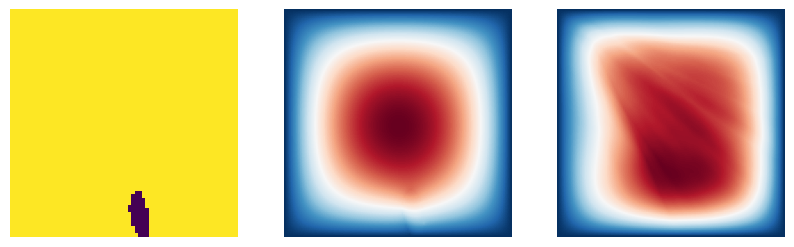

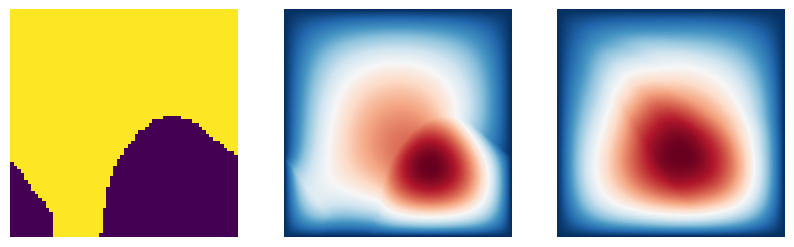

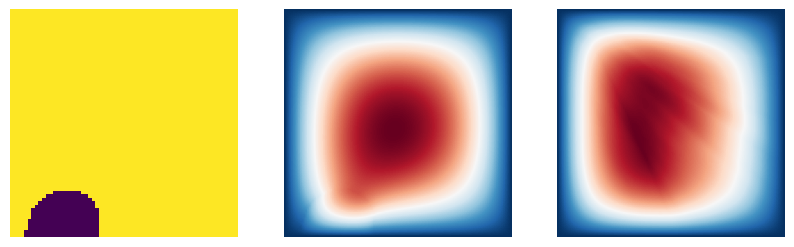

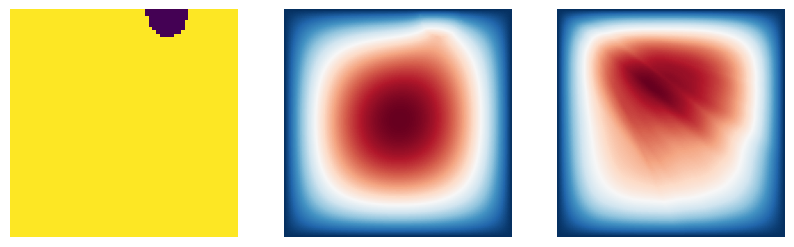

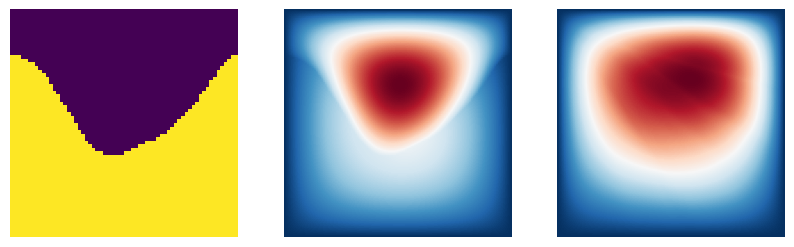

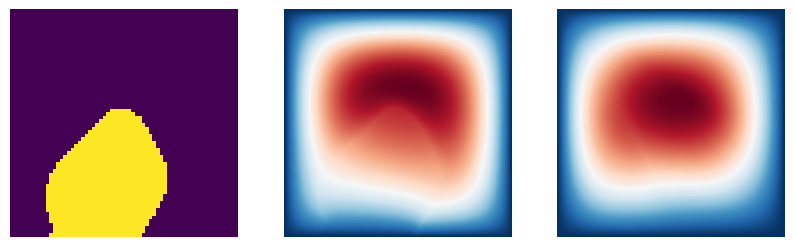

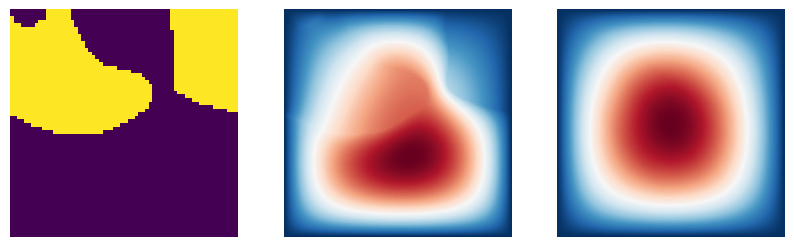

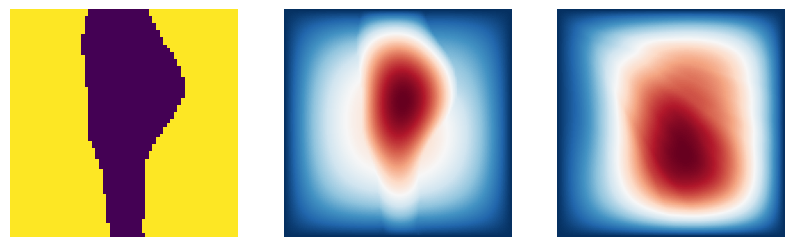

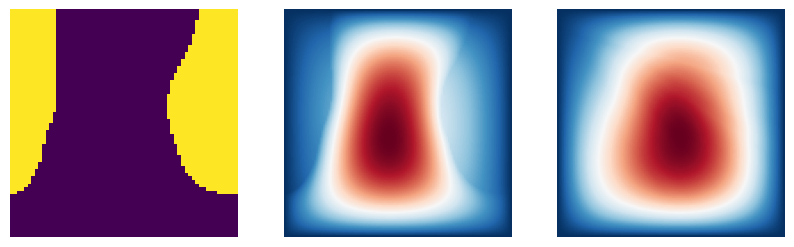

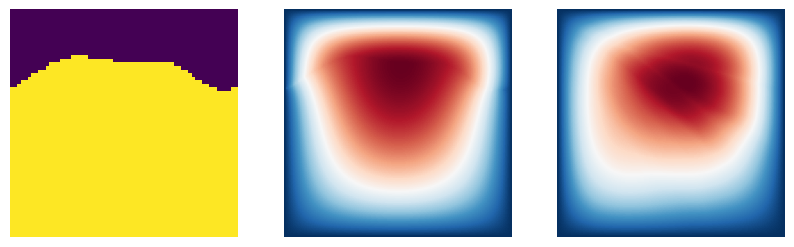

In [ ]:
import matplotlib.pyplot as plt

for a, u in test_dataset.take(10):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    a = tf.reshape(a, (-1, 64*64))
    u = tf.reshape(u, (-1, 128*128))

    u_pred = model(a, coords_test)
    u_pred = tf.reshape(u_pred, (-1, 128*128))
    ax[0].imshow(tf.reshape(a[1], (64, 64)), cmap = "viridis")
    ax[0].set_axis_off()
    ax[1].imshow(tf.reshape(u[1], (128, 128)), cmap = "RdBu_r")
    ax[1].set_axis_off()
    ax[2].imshow(tf.reshape(u_pred[1], (128, 128)), cmap = "RdBu_r")
    ax[2].set_axis_off()
    
    plt.show()